# Visualization of training samples

# table of content
1) [Path to files to process](#path-to-files-to-process)
2) [Visualiization of tiles from above](#visualization-of-tiles-from-above)
3) [Analysis of training pickles](#analysis-of-training-pickles)
4) [Show cylinders on full tiles](#show-cylinders-on-full-tiles)
5) [Extract statistics](#extract-statistics)

### Dependencies and general utils

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import open3d as o3d
import laspy
import pickle
import pdal
import json
from tqdm import tqdm

### Path to files to process

In [4]:
# src_data = "../data/training_sample_visualization/training_samples"
# src_tiles = "../data/training_sample_visualization"
src_tiles = r"D:\PDM_repo\Github\PDM\results\trainings\20250427_140314_test\pseudo_labels"
src_pickles = r"D:\PDM_repo\Github\PDM\data\dataset_tiles_100m\training_samples\loop2"

### Visualization of tiles from above

In [3]:
# loading
tile_src = "../data/training_sample_visualization/color_grp_full_tile_311_out_gt.laz"
tile = laspy.read(tile_src)
print(list(tile.point_format.dimension_names))

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'PredSemantic', 'PredInstance', 'gt_semantic_segmentation', 'gt_instance_segmentation']


#### utils

In [4]:
def plot_las_top_down(las_path, point_size=0.5, color_by='z'):
    """
    Load a LAS/LAZ file and generate a top-down image (XY plane) colored by height or intensity.

    Parameters:
    - las_path: str, path to the .las or .laz file
    - point_size: float, size of each point in the scatter plot
    - color_by: str, either 'z' or 'intensity', to color points
    """
    # Load LAS file
    las = laspy.read(las_path)

    # Get coordinates
    x = las.x
    y = las.y

    # Get values for coloring
    try:
        c = las.__getattr__(color_by)
    except Exception as e:
        print("Not working!\n", e)
    # if color_by == 'z':
    #     c = las.z
    # elif color_by == 'intensity' and 'intensity' in las.point_format.dimension_names:
    #     c = las.intensity
    # else:
    #     raise ValueError("color_by must be 'z' or 'intensity' and available in the file")

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, c=c, s=point_size, cmap='viridis', marker='.')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Top-Down View (colored by {color_by})")
    plt.colorbar(label=color_by)
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

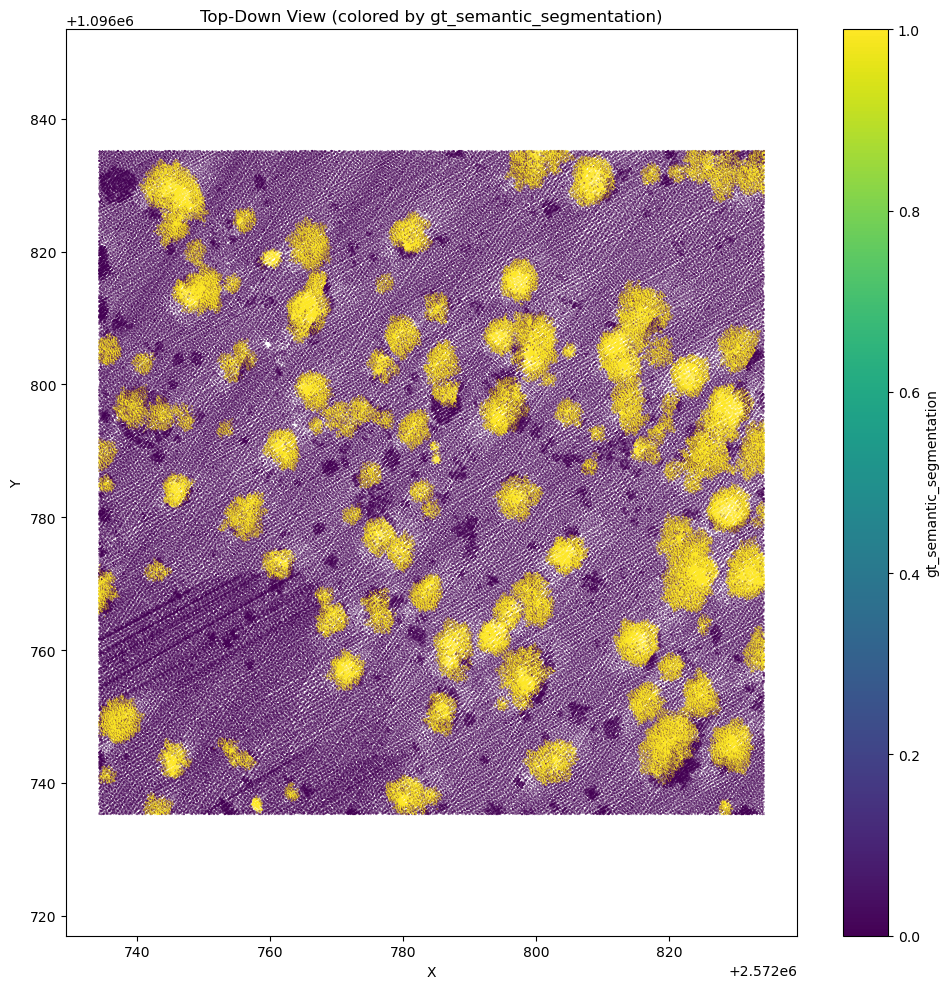

In [5]:
plot_las_top_down(tile_src, point_size=0.2, color_by='gt_semantic_segmentation')

### Analysis of training pickles

In [5]:
# get all centers
list_centers = []
files = [x for x in os.listdir(src_pickles) if x.endswith('pickle')]
for file in files:
    # print(file)
    with open(os.path.join(src_pickles, file), 'rb') as in_file:
        training_pickle = pickle.load(in_file)
    for center in training_pickle:
        # print(tuple(center[0]))
        # list_centers.append(str(center[0][0]) + str(center[0][1]))
        list_centers.append(tuple(center[0]))
print("Total number of centers: ", len(list_centers))
list_centers = set(list_centers)
print("Without duplicates: ", len(list_centers))

Total number of centers:  200
Without duplicates:  200


In [6]:
# associate centers to tiles:
tiles = [x for x in os.listdir(src_tiles) if x.endswith('laz')]
# tiles_to_type = {
#     "color_grp_full_tile_128_out_gt.laz": "light slope sample",
#     "color_grp_full_tile_129_out_gt.laz": "bushes sample",
#     "color_grp_full_tile_160_out_gt.laz": "slope empty sample",
#     "color_grp_full_tile_210_out_gt.laz": "flat empty sample",
#     "color_grp_full_tile_311_out_gt.laz": "flat sample",
#     "color_grp_full_tile_633_out_gt.laz": "heavy slope sample",
# }
centers_to_tiles = {tile_src: [] for tile_src in tiles}
for tile_src in tiles:
    tile = laspy.read(os.path.join(src_tiles, tile_src))
    x_min = tile.x.min()
    x_max = tile.x.max()
    y_min = tile.y.min()
    y_max = tile.y.max()
    for center in list_centers:
        if center[0] > x_min and center[0] < x_max and center[1] > y_min and center[1] < y_max:
            centers_to_tiles[tile_src].append(center)

# for key, lst in centers_to_tiles.items():
#     print(key)
#     for val in lst:
#         print("\t", val)

lst_full = {x:y for x,y in centers_to_tiles.items() if len(y) > 0}
lst_empty = {x:y for x,y in centers_to_tiles.items() if len(y) == 0}

# print("Full tiles: ")
# for x,y in lst_full.items():
#     print(f"\t{tiles_to_type[x]} ({len(y)} samples)")
# print("Empty tiles: ")
# for x in lst_empty.keys():
#     print("\t", tiles_to_type[x])
print("Full tiles: ")
for x,y in lst_full.items():
    print(f"\t{x} ({len(y)} samples)")
print("Empty tiles: ")
for x in lst_empty.keys():
    print("\t", x)

Full tiles: 
	color_grp_full_tile_100.laz (25 samples)
	color_grp_full_tile_101.laz (11 samples)
	color_grp_full_tile_317.laz (31 samples)
	color_grp_full_tile_318.laz (16 samples)
	color_grp_full_tile_319.laz (35 samples)
	color_grp_full_tile_320.laz (20 samples)
	color_grp_full_tile_321.laz (29 samples)
	color_grp_full_tile_322.laz (26 samples)
	color_grp_full_tile_94.laz (6 samples)
	color_grp_full_tile_97.laz (1 samples)
Empty tiles: 
	 color_grp_full_tile_1.laz
	 color_grp_full_tile_10.laz
	 color_grp_full_tile_11.laz
	 color_grp_full_tile_12.laz
	 color_grp_full_tile_2.laz
	 color_grp_full_tile_3.laz
	 color_grp_full_tile_323.laz
	 color_grp_full_tile_4.laz
	 color_grp_full_tile_5.laz
	 color_grp_full_tile_6.laz
	 color_grp_full_tile_7.laz
	 color_grp_full_tile_8.laz
	 color_grp_full_tile_9.laz
	 color_grp_full_tile_99.laz


### Show cylinders on full tiles

#### utils

In [7]:
def plot_las_plus_centers(las_path, lst_centers, title="", point_size=0.5, radius=8, color_by='z'):
    """
    Load a LAS/LAZ file and generate a top-down image (XY plane) colored by height or intensity.

    Parameters:
    - las_path: str, path to the .las or .laz file
    - point_size: float, size of each point in the scatter plot
    - color_by: str, either 'z' or 'intensity', to color points
    """
    # Load LAS file
    las = laspy.read(las_path)

    # Get coordinates
    x = las.x
    y = las.y

    # Get values for coloring
    try:
        c = las.__getattr__(color_by)
    except Exception as e:
        print("Not working!\n", e)
    # if color_by == 'z':
    #     c = las.z
    # elif color_by == 'intensity' and 'intensity' in las.point_format.dimension_names:
    #     c = las.intensity
    # else:
    #     raise ValueError("color_by must be 'z' or 'intensity' and available in the file")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    # plt.scatter(x, y, c=c, s=point_size, cmap='viridis', marker='.')
    sc = ax.scatter(x, y, c=c, s=point_size, cmap='viridis', marker='.')
    plt.xlabel("X")
    plt.ylabel("Y")
    if title == "":
        plt.title(f"{os.path.basename(las_path)} (colored by {color_by})")
    else:
        plt.title(f"{title} (colored by {color_by})")
         
    plt.colorbar(sc, label=color_by)
    # plt.axis("equal")
    ax.set_aspect('equal')
    for (px, py) in lst_centers:
            circle = Circle((px, py), radius=radius, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(circle)
    plt.tight_layout()
    plt.show()

#### show centers

In [ ]:
for tile_src in tiles:
    plot_las_plus_centers(
        os.path.join(src_tiles, tile_src), 
        centers_to_tiles[tile_src], 
        # title=tiles_to_type[tile_src],
        point_size=0.2, 
        color_by='classification',
        )

### Extract statistics

#### Utils

In [10]:
def extract_points_in_circle(center, las, lst_features, radius=8):
    """
    Extract indices and coordinates of points within given circles.

    Parameters:
    - x, y: np.ndarray, point coordinates (from las.x and las.y)
    - las: laspy.LasData, the LAS file object
    - centers: list of (x, y) tuples representing circle centers
    - radius: float, radius of the circle

    Returns:
    - list of np.ndarray, each containing the indices of points inside a circle
    """
    results = {}
    cx, cy = center
    dist = np.sqrt((las.x - cx)**2 + (las.y - cy)**2)
    mask = dist <= radius
    # results.append(np.where(mask)[0])  # Store indices
    # results = {}
    for feature in lst_features:
        results[feature] = las[feature][mask]

    return results

#### Extract

In [18]:
# prepare dict of stats:
list_of_stats = ["semantic_frac_ground", "semantic_frac_tree", "", "frac_grey", "frac_ground", "frac_tree"]
stats_tot = {x:[] for x in list_of_stats}
tile_test = laspy.read(os.path.join(src_tiles, tiles[0]))
lst_features = list(tile_test.point_format.dimension_names)
print(lst_features)
print(set(tile_test.classification))
# print(set(tile_test.gt_semantic_segmentation))
center_points = {x:[] for x in lst_features}
print("Centers:\n", list_centers)
# loop on centers:
for idx, center in tqdm(enumerate(list_centers), total=len(list_centers), desc="Extracting data"):
    # find corresponding tile
    src_corresponding_tile = ""
    for tile_name, lst_centers in centers_to_tiles.items():
        if center in lst_centers:
            src_corresponding_tile = os.path.join(src_tiles, tile_name)
            break
    if src_corresponding_tile == "":
        print("DID NOT FIND A CORRESPONDING TILE TO ", center)
        break

    # find matching points
    tile = laspy.read(src_corresponding_tile)
    results = extract_points_in_circle(center, tile, lst_features)
    for feature, vals in results.items():
        center_points[feature].append(vals)
    
# Computing stats
# gt_semantic = center_points["gt_semantic_segmentation"]
# stats_tot['semantic_frac_ground'] = [len(x[x == 0])/len(x) for x in gt_semantic]
# stats_tot['semantic_frac_tree'] = [len(x[x == 1])/len(x) for x in gt_semantic]
pseudo_labels_semantic = center_points['classification']
stats_tot['frac_grey'] = [len(x[x == 0])/len(x) for x in pseudo_labels_semantic if 0 in x]
stats_tot['frac_ground'] = [len(x[x == 1])/len(x) for x in pseudo_labels_semantic if 1 in x]
stats_tot['frac_tree'] = [len(x[x == 4])/len(x) for x in pseudo_labels_semantic if 4 in x]

for x in pseudo_labels_semantic:
    print(set(x))

print(np.mean(stats_tot['semantic_frac_ground']))
print(np.mean(stats_tot['semantic_frac_tree']))


    

    



['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'treeID']
{0, 1}
Centers:
 {(2571375.5, 1096486.5), (2572772.8, 1097098.4), (2571354.2, 1096511.4), (2572760.8, 1096944.2), (2571451.8, 1096562.6), (2571381.5, 1096511.4), (2571293.5, 1096572.2), (2572845.5, 1097014.4), (2571460.0, 1096549.1), (2572780.5, 1097043.4), (2571357.5, 1096465.8), (2572913.0, 1097018.5), (2572886.5, 1097061.5), (2572777.8, 1097051.1), (2572891.0, 1096969.0), (2572874.0, 1097118.5), (2572814.0, 1097042.2), (2572736.8, 1097053.0), (2572916.0, 1097050.4), (2571315.8, 1096600.6), (2572755.0, 1097072.5), (2572790.5, 1097129.8), (2571273.5, 1096541.8), (2572801.0, 1097023.9), (2572706.5, 1097096.6), (2571341.0, 1096524.2), (2571485.5, 1096625.1), (2572817.5, 1097082.8), (2572852.8, 1097120

Extracting data: 100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}
{0, 1, 4}


c:\ProgramData\Miniconda3\envs\PDM\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\Miniconda3\envs\PDM\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


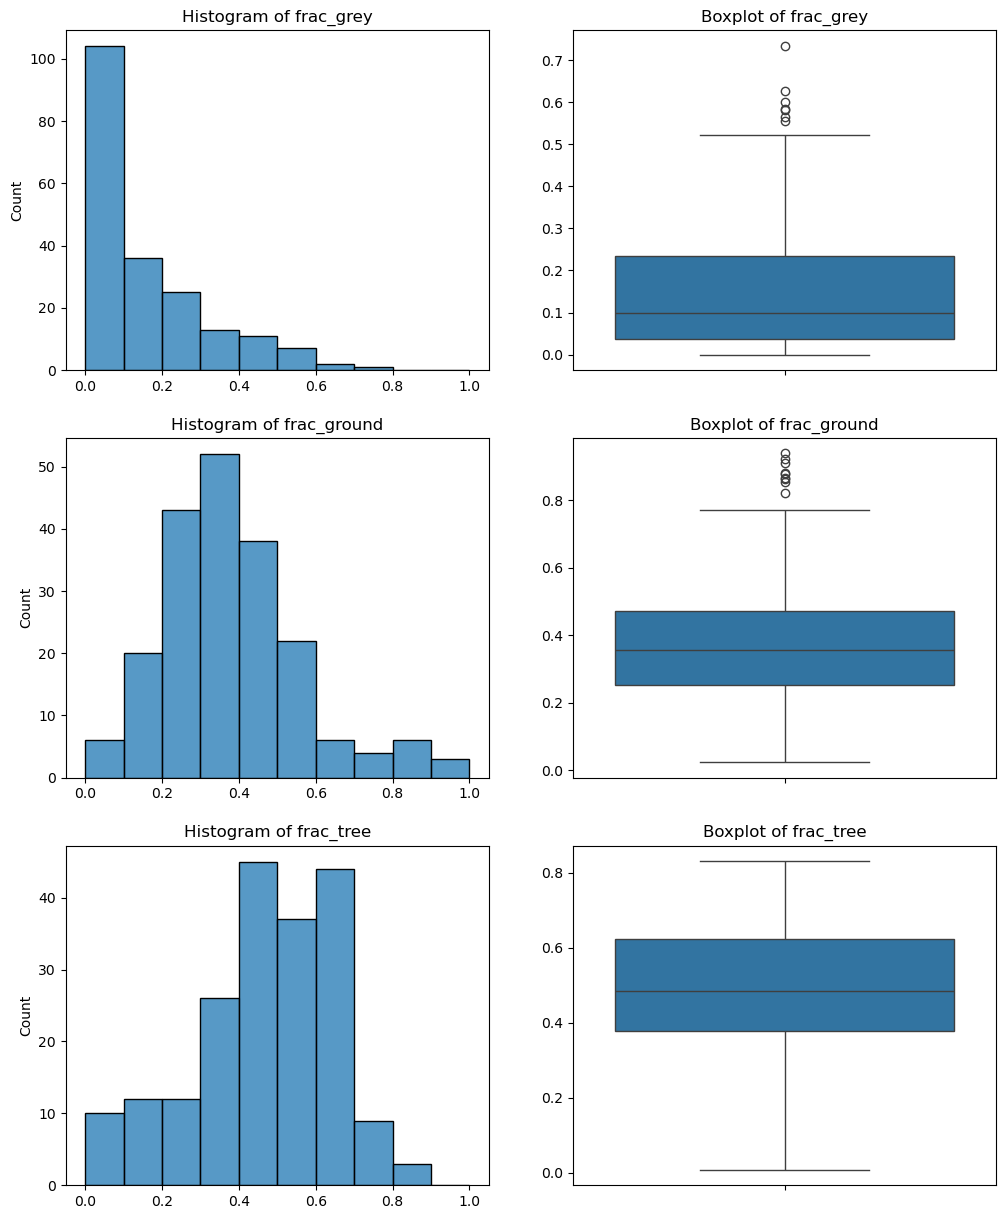

In [31]:
# Showing distribution
fig, axs = plt.subplots(3,2, figsize=(12, 15))
axs = axs.flatten()
lst_metrics = ['frac_grey', 'frac_ground', 'frac_tree']
for idx, metric in enumerate(lst_metrics):
    sns.histplot(stats_tot[metric], bins=10, binrange=(0.0, 1.0), ax=axs[2*idx])
    sns.boxplot(stats_tot[metric], ax=axs[2*idx + 1])
    axs[2*idx].set_title(f"Histogram of {metric}")
    axs[2*idx + 1].set_title(f"Boxplot of {metric}")
    # axs[0].hist(stats_tot['semantic_frac_tree'])
    # axs[1].boxplot(stats_tot['semantic_frac_tree'])